In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib import patches
import seaborn as sns
%matplotlib notebook

In [ ]:
from objective_function import *
from optimiser import *

In [379]:
def sample_from_square(edge, center, num):
    points = np.zeros((num, 2))
    for i in range(num):
        rx = (np.random.rand() - 0.5) * edge[0] + center[0] 
        ry = (np.random.rand() - 0.5) * edge[1] + center[1]
        if rx < ry:
            points[i, :] = np.array([ry, rx]) 
        else:
            points[i, :] = np.array([rx, ry])
    return points

<IPython.core.display.Javascript object>


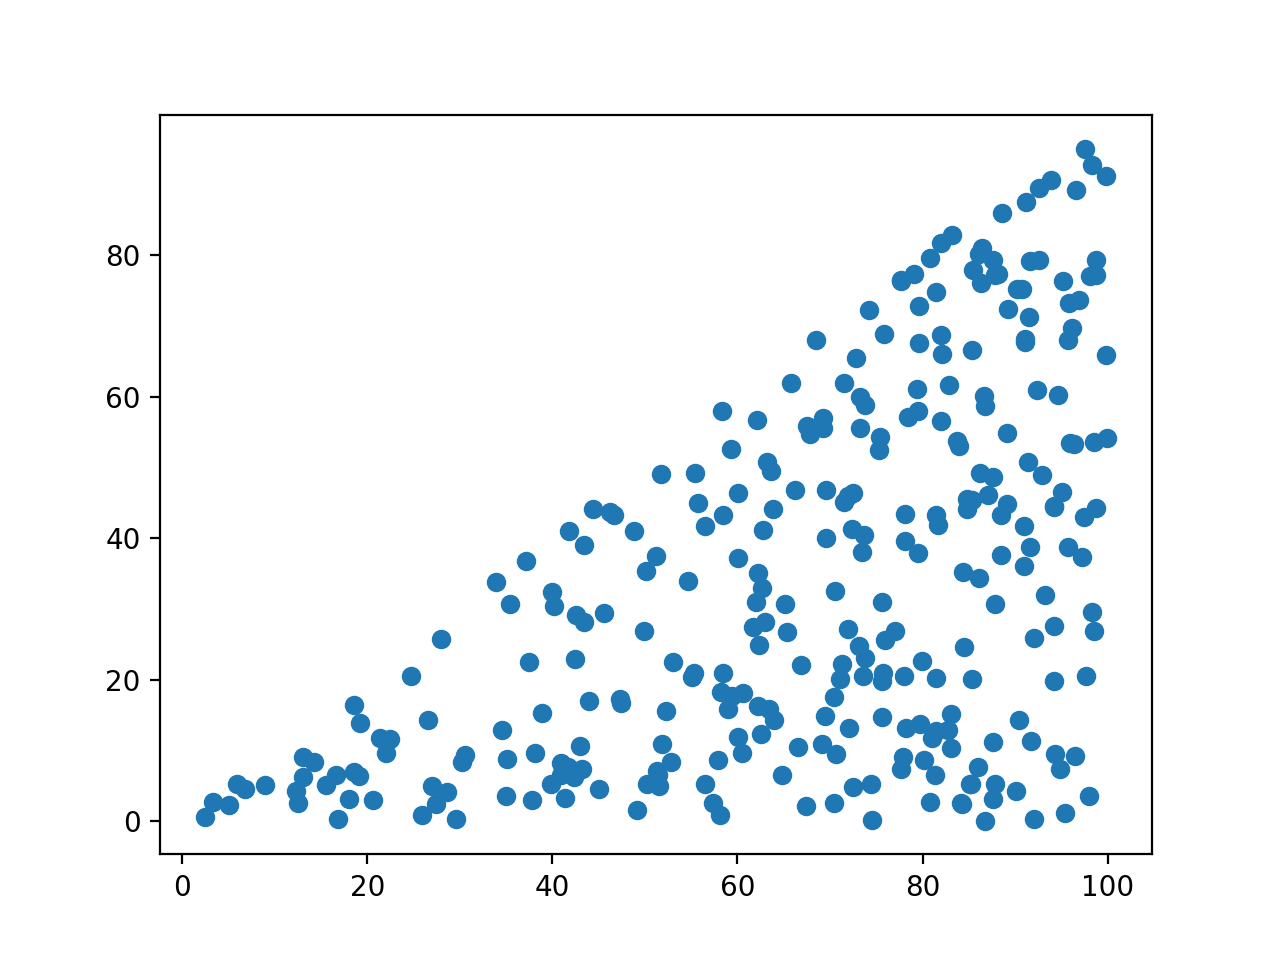

In [387]:
plt.scatter(points[:,0], points[:,1])

In [440]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
# setup optmizer
paras = {}
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = default
paras['multi_runs'] = True
cma = cma_es()

# boil down to one expreiment
exp1 = single_experiment()
exp1.set_objective(ak)

num = 300
points1 = sample_from_square([100,100], [50,50], num)
res1 = np.zeros((num, ))

for i in range(num):
    paras['mean0'] = points1[i,:].reshape(2,1)
    cma.set_parameters(paras)
    exp1.set_optimise(cma)
    status = exp1.do()
    if(status == 'global minimum'):
        res1[i] = 1
    else:
        res1[i] = 0

*******starting optimisation from intitial mean:  [81.14036263 44.77642448]
eigenvalue of variance = [1.67453838e-02 5.99742418e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [-83169.0662066  -14660.18123394], found minimum = 20.77041585637273
dist_val 20.77041585637273
local minimum
*******starting optimisation from intitial mean:  [88.1898807  62.77456561]
eigenvalue of variance = [1.17066199e-02 2.03921028e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [3137.09291709   31.01495069], found minimum = 20.221560563054222
dist_val 20.221560563054222
local minimum
*******starting optimisation from intitial mean:  [88.33665903 66.5074747 ]
eigenvalue of variance = [0.25659641 0.16665976]
total iterations = 55, total evaluatios = 330
found minimum position = [92.99995598 70.9999617 ], found minimum = 19.999998788750933
dist_val 19.999998788750933
local minimum
*******starting optimisation from intitial mean:  [71.16700774 66.5271

global minimum
*******starting optimisation from intitial mean:  [12.65788346 12.52587095]
eigenvalue of variance = [0.03023513 0.04377833]
total iterations = 86, total evaluatios = 516
found minimum position = [1.30017314e-06 2.01180155e-06], found minimum = 6.775281232496155e-06
global minimum
*******starting optimisation from intitial mean:  [70.06850594 12.46117305]
eigenvalue of variance = [1.65124529e-05 6.84129679e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [  468.84187269 72697.89064051], found minimum = 20.7846533980881
dist_val 20.7846533980881
local minimum
*******starting optimisation from intitial mean:  [99.46225693 77.30381745]
eigenvalue of variance = [0.14059717 0.1918552 ]
total iterations = 72, total evaluatios = 432
found minimum position = [106.00005327  79.0001231 ], found minimum = 20.00000033078736
dist_val 20.00000033078736
local minimum
*******starting optimisation from intitial mean:  [42.18180497 28.01974529]
eigenvalue of v

eigenvalue of variance = [0.00010668 0.00156316]
total iterations = 400, total evaluatios = 2400
found minimum position = [15467.97412235 56368.18672954], found minimum = 20.73057615747437
dist_val 20.73057615747437
local minimum
*******starting optimisation from intitial mean:  [52.76474372 14.44148542]
eigenvalue of variance = [0.31275054 0.27037741]
total iterations = 51, total evaluatios = 306
found minimum position = [58.99992624 15.00009755], found minimum = 19.99635233601135
dist_val 19.99635233601135
local minimum
*******starting optimisation from intitial mean:  [97.31621664  7.53604102]
eigenvalue of variance = [0.51706102 0.36042712]
total iterations = 49, total evaluatios = 294
found minimum position = [91.9998325  12.00029691], found minimum = 19.9999630614713
dist_val 19.9999630614713
local minimum
*******starting optimisation from intitial mean:  [95.67600544  3.85433904]
eigenvalue of variance = [4.05799713e-06 1.07913266e-02]
total iterations = 400, total evaluatios = 

eigenvalue of variance = [0.01072728 0.0146477 ]
total iterations = 110, total evaluatios = 660
found minimum position = [ 1.72941555e-06 -2.89010316e-08], found minimum = 4.892288494762198e-06
global minimum
*******starting optimisation from intitial mean:  [70.07346569 35.72027889]
eigenvalue of variance = [0.08813087 0.00010073]
total iterations = 400, total evaluatios = 2400
found minimum position = [2.72375970e+09 1.50463859e+07], found minimum = 20.52355473921122
dist_val 20.52355473921122
local minimum
*******starting optimisation from intitial mean:  [94.47991076 53.48946205]
eigenvalue of variance = [0.39050483 0.22694868]
total iterations = 61, total evaluatios = 366
found minimum position = [94.00007005 51.99999751], found minimum = 19.999995083108704
dist_val 19.999995083108704
local minimum
*******starting optimisation from intitial mean:  [98.54659806  4.70340537]
eigenvalue of variance = [0.12071589 0.22786977]
total iterations = 90, total evaluatios = 540
found minimum 

eigenvalue of variance = [8.72602892e-06 6.54979036e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [-2.72411005e+06 -5.10016143e+08], found minimum = 20.761369943510903
dist_val 20.761369943510903
local minimum
*******starting optimisation from intitial mean:  [63.01477001  8.21554006]
eigenvalue of variance = [0.05766011 0.09384305]
total iterations = 112, total evaluatios = 672
found minimum position = [49.99995333 19.00001305], found minimum = 19.989628136237663
dist_val 19.989628136237663
local minimum
*******starting optimisation from intitial mean:  [95.90053935 21.05823932]
eigenvalue of variance = [0.04228336 0.03080625]
total iterations = 136, total evaluatios = 816
found minimum position = [-1.57717687e-06 -9.38732213e-07], found minimum = 5.19139400667612e-06
global minimum
*******starting optimisation from intitial mean:  [52.4263723  16.26235424]
eigenvalue of variance = [0.11512614 0.08145964]
total iterations = 101, total evaluatios = 606
f

eigenvalue of variance = [0.02678534 0.01984478]
total iterations = 96, total evaluatios = 576
found minimum position = [2.06772370e-06 6.99160012e-07], found minimum = 6.1738168715130826e-06
global minimum
*******starting optimisation from intitial mean:  [73.08227565 71.43462394]
eigenvalue of variance = [0.12257818 0.078092  ]
total iterations = 102, total evaluatios = 612
found minimum position = [65.00004113 74.00004602], found minimum = 19.99998224997891
dist_val 19.99998224997891
local minimum
*******starting optimisation from intitial mean:  [73.6571494  31.46122366]
eigenvalue of variance = [8.72823423e-05 7.24623782e-04]
total iterations = 400, total evaluatios = 2400
found minimum position = [-14635.77691994  75299.08337576], found minimum = 21.04110009450841
dist_val 21.04110009450841
local minimum
*******starting optimisation from intitial mean:  [29.65594503 17.98369307]
eigenvalue of variance = [0.02122665 0.01956929]
total iterations = 90, total evaluatios = 540
found m

eigenvalue of variance = [0.25629887 0.50598765]
total iterations = 47, total evaluatios = 282
found minimum position = [57.00010271 14.99991625], found minimum = 19.995203378080763
dist_val 19.995203378080763
local minimum
*******starting optimisation from intitial mean:  [88.29803312 59.64345591]
eigenvalue of variance = [0.2255188  0.34767409]
total iterations = 59, total evaluatios = 354
found minimum position = [89.00010991 59.99978829], found minimum = 19.999996414259993
dist_val 19.999996414259993
local minimum
*******starting optimisation from intitial mean:  [78.80478678 52.30031871]
eigenvalue of variance = [0.17891479 0.25379922]
total iterations = 74, total evaluatios = 444
found minimum position = [88.0000062 44.0000654], found minimum = 19.999981992149603
dist_val 19.999981992149603
local minimum
*******starting optimisation from intitial mean:  [65.99658866 15.09611217]
eigenvalue of variance = [0.04298161 0.02757028]
total iterations = 106, total evaluatios = 636
found 

eigenvalue of variance = [5.51644371e-05 1.45245695e-01]
total iterations = 400, total evaluatios = 2400
found minimum position = [-2.30143141e+05  5.68418991e+08], found minimum = 20.90208708513644
dist_val 20.90208708513644
local minimum
*******starting optimisation from intitial mean:  [97.02026803  6.52220974]
eigenvalue of variance = [0.15029195 0.11242423]
total iterations = 91, total evaluatios = 546
found minimum position = [100.99977091  10.0000268 ], found minimum = 19.999989747303253
dist_val 19.999989747303253
local minimum
*******starting optimisation from intitial mean:  [45.66710858 40.91936705]
eigenvalue of variance = [2.80112181e-02 7.14810608e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [-6768215.67323489   -15818.1388863 ], found minimum = 21.62467856736347
dist_val 21.62467856736347
local minimum
*******starting optimisation from intitial mean:  [82.0426435   3.47311983]
eigenvalue of variance = [0.0012639  0.00091297]
total iterati

eigenvalue of variance = [6.43735973e-05 9.96386860e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [-147581.17819738  885973.91411248], found minimum = 20.808584029839803
dist_val 20.808584029839803
local minimum
*******starting optimisation from intitial mean:  [25.58294855 12.98410556]
eigenvalue of variance = [0.36745672 0.45024014]
total iterations = 58, total evaluatios = 348
found minimum position = [22.99910445 18.99940526], found minimum = 19.70572085682642
dist_val 19.70572085682642
local minimum
*******starting optimisation from intitial mean:  [95.93416587 11.28536073]
eigenvalue of variance = [0.00841647 0.01182891]
total iterations = 130, total evaluatios = 780
found minimum position = [-9.26977111e-07  2.87379318e-07], found minimum = 2.7450182469301865e-06
global minimum
*******starting optimisation from intitial mean:  [51.01929163 12.97538238]
eigenvalue of variance = [0.0249986  0.04010336]
total iterations = 98, total evaluatios = 588
f

eigenvalue of variance = [0.01861744 0.0231327 ]
total iterations = 98, total evaluatios = 588
found minimum position = [-1.99309357e-06  9.47325027e-07], found minimum = 6.241826039588005e-06
global minimum
*******starting optimisation from intitial mean:  [99.35023249 44.68203347]
eigenvalue of variance = [0.36125621 0.4217679 ]
total iterations = 65, total evaluatios = 390
found minimum position = [104.00025863  44.00019188], found minimum = 20.00000046299204
dist_val 20.00000046299204
local minimum
*******starting optimisation from intitial mean:  [68.72505018 37.25708567]
eigenvalue of variance = [0.24490007 0.32590401]
total iterations = 59, total evaluatios = 354
found minimum position = [71.00022819 29.00011097], found minimum = 19.999612170638567
dist_val 19.999612170638567
local minimum
*******starting optimisation from intitial mean:  [29.45745282 27.72201243]
eigenvalue of variance = [0.01657973 0.01753324]
total iterations = 113, total evaluatios = 678
found minimum positi

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:150: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning:

invalid value encountered in less

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning:

invalid value encountered in less



eigenvalue of variance = [0.21318421 0.18260526]
total iterations = 69, total evaluatios = 414
found minimum position = [95.99998775 84.99988729], found minimum = 20.000000078307583
dist_val 20.000000078307583
local minimum
*******starting optimisation from intitial mean:  [54.06398031 11.69957542]
eigenvalue of variance = [6.84564461e-05 1.65681125e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [-3.32287172e+06 -1.27177094e+08], found minimum = 21.248933198540023
dist_val 21.248933198540023
local minimum
*******starting optimisation from intitial mean:  [66.38663962 62.70700172]
eigenvalue of variance = [0.17368356 0.22290166]
total iterations = 96, total evaluatios = 576
found minimum position = [67.99979406 69.00028467], found minimum = 19.999980871407182
dist_val 19.999980871407182
local minimum
*******starting optimisation from intitial mean:  [35.3884908  27.15579832]
eigenvalue of variance = [0.14001968 0.11664373]
total iterations = 100, total eva

<IPython.core.display.Javascript object>


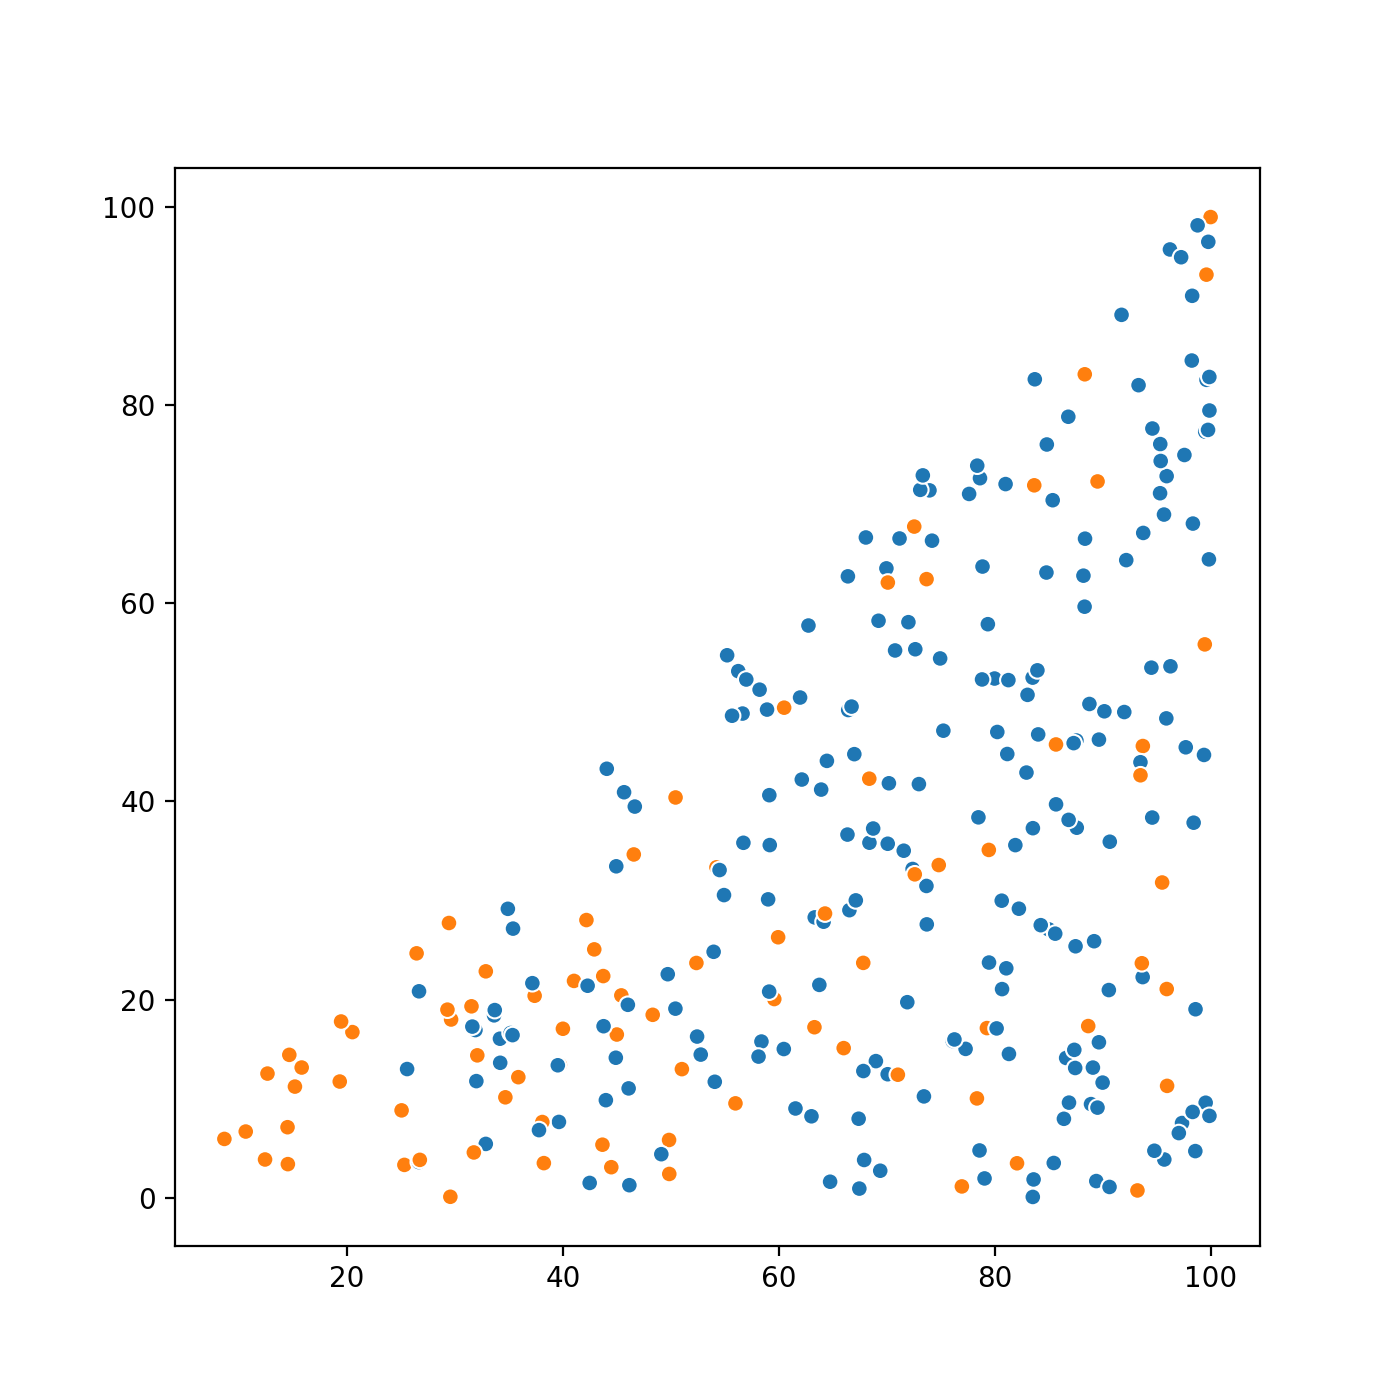

In [441]:
pa = post_analysis_multi(points1, res1)
pa.plot_cloud_point()

<IPython.core.display.Javascript object>


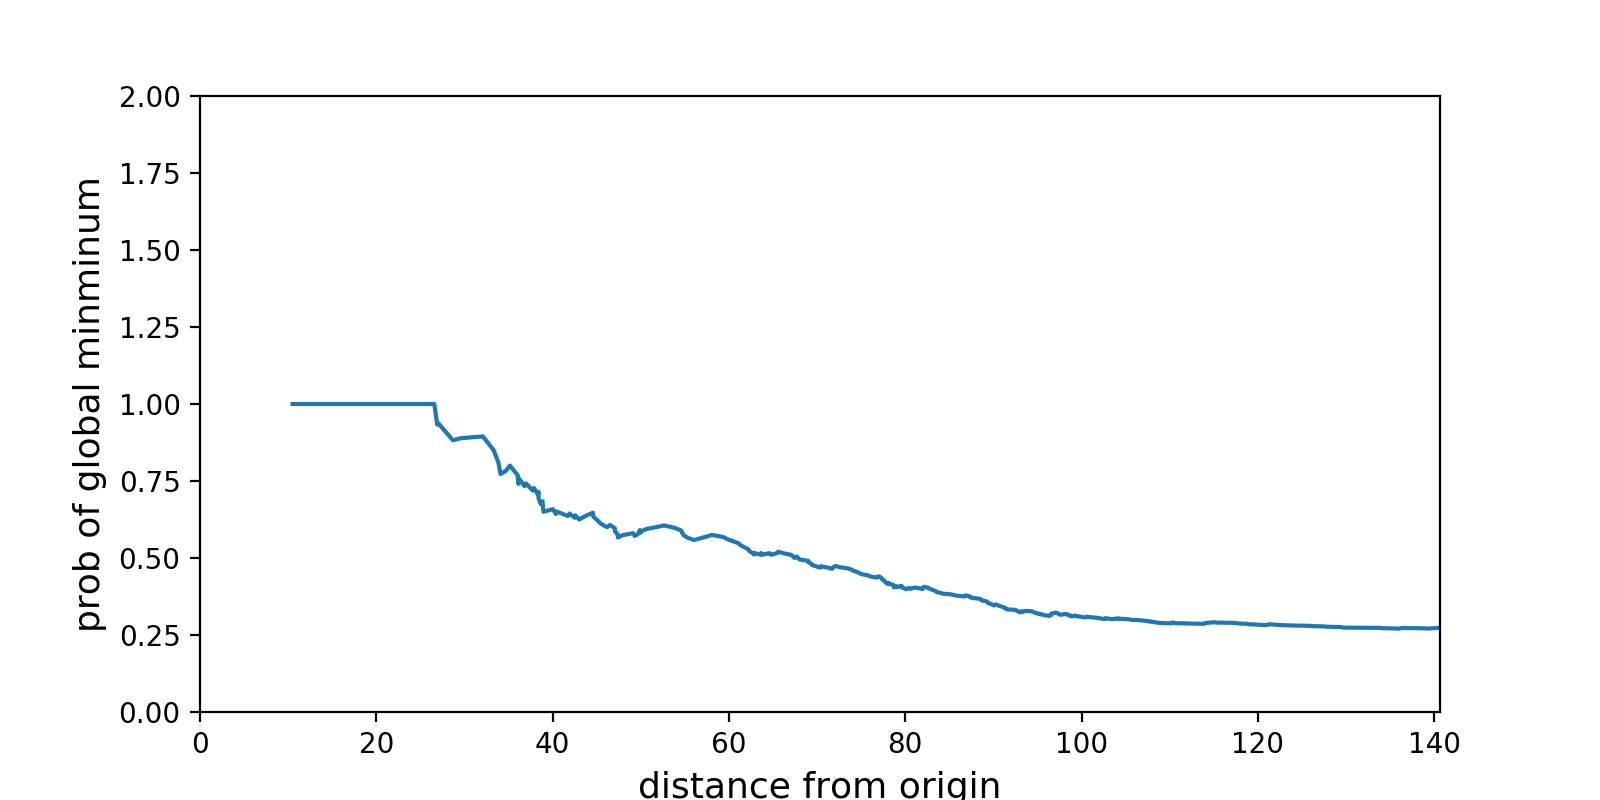

In [442]:
pa.plot_prob_vs_radius()

In [426]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
ro = round_off()
# setup optmizer
paras = {}
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro
paras['multi_runs'] = True
cma = cma_es()

# boil down to one expreiment
exp2 = single_experiment()
exp2.set_objective(ak)

num = 300

res2 = np.zeros((num, ))
points2 = sample_from_square([100,100], [50,50], num)

for i in range(num):
    paras['mean0'] = points[i,:].reshape(2,1)
    cma.set_parameters(paras)
    exp2.set_optimise(cma)
    status = exp2.do()
    if(status == 'global minimum'):
        res2[i] = 1
    else:
        res2[i] = 0

*******starting optimisation from intitial mean:  [81.14036263 44.77642448]
eigenvalue of variance = [1.82780267 0.85962141]
total iterations = 36, total evaluatios = 216
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [88.1898807  62.77456561]
eigenvalue of variance = [1.01621042 1.14926326]
total iterations = 48, total evaluatios = 288
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [88.33665903 66.5074747 ]
eigenvalue of variance = [1.61925097 1.23901075]
total iterations = 43, total evaluatios = 258
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [71.16700774 66.52716516]
eigenvalue of variance = [0.95777055 0.71469054]
total iterations = 38, total evaluatios = 228
found minimum position = [ 0. -0.], found minimum =

eigenvalue of variance = [1.252123   0.72414178]
total iterations = 44, total evaluatios = 264
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [66.98033108 44.76131881]
eigenvalue of variance = [1.14864365 1.96011657]
total iterations = 36, total evaluatios = 216
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [67.38098001  7.97069093]
eigenvalue of variance = [1.06283456 0.71431535]
total iterations = 31, total evaluatios = 186
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [95.89266429 72.82007516]
eigenvalue of variance = [0.88702854 1.76852019]
total iterations = 47, total evaluatios = 282
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from in

eigenvalue of variance = [1.69686057 1.45074623]
total iterations = 35, total evaluatios = 210
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [56.23832737 53.13738779]
eigenvalue of variance = [0.4628887  1.01900861]
total iterations = 47, total evaluatios = 282
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [34.6784386  10.13126942]
eigenvalue of variance = [1.98732156 1.18790968]
total iterations = 24, total evaluatios = 144
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [54.50706988 33.06710391]
eigenvalue of variance = [1.36803172 1.02364024]
total iterations = 35, total evaluatios = 210
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from inti

eigenvalue of variance = [1.01387808 1.22511812]
total iterations = 35, total evaluatios = 210
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [90.62944286 35.92434722]
eigenvalue of variance = [1.65067141 1.24464554]
total iterations = 40, total evaluatios = 240
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [73.66798731 62.42449523]
eigenvalue of variance = [0.74376841 0.57190991]
total iterations = 42, total evaluatios = 252
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [49.1150554   4.39160521]
eigenvalue of variance = [4.20066072 1.71445338]
total iterations = 32, total evaluatios = 192
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intiti

eigenvalue of variance = [0.98938504 0.63788484]
total iterations = 46, total evaluatios = 276
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [68.97827757 13.78436895]
eigenvalue of variance = [1.42923127 1.02681657]
total iterations = 38, total evaluatios = 228
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [25.07190379  8.81384448]
eigenvalue of variance = [1.33102464 1.26477799]
total iterations = 24, total evaluatios = 144
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [67.80703447 23.69789949]
eigenvalue of variance = [2.56166547 1.31581752]
total iterations = 30, total evaluatios = 180
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from inti

eigenvalue of variance = [1.68803598 1.19717268]
total iterations = 35, total evaluatios = 210
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [85.4429884   3.50450971]
eigenvalue of variance = [1.91609219 1.69061704]
total iterations = 45, total evaluatios = 270
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [88.74335847 49.82448283]
eigenvalue of variance = [0.78990607 1.05855731]
total iterations = 40, total evaluatios = 240
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [94.57229433 77.62449459]
eigenvalue of variance = [0.36364559 0.28738951]
total iterations = 51, total evaluatios = 306
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from in

eigenvalue of variance = [1.15465657 1.05183828]
total iterations = 32, total evaluatios = 192
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [99.85469596  8.25892556]
eigenvalue of variance = [1.01789123 1.1933236 ]
total iterations = 35, total evaluatios = 210
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [46.65972104 39.4716282 ]
eigenvalue of variance = [1.82489131 0.93265818]
total iterations = 37, total evaluatios = 222
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [83.9287187  53.22051882]
eigenvalue of variance = [0.80656211 1.189694  ]
total iterations = 39, total evaluatios = 234
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from in

eigenvalue of variance = [0.97612453 1.19912526]
total iterations = 34, total evaluatios = 204
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [93.18939544  0.73265898]
eigenvalue of variance = [1.55282522 1.05213397]
total iterations = 41, total evaluatios = 246
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [34.90957205 29.153497  ]
eigenvalue of variance = [1.11496491 1.40763079]
total iterations = 30, total evaluatios = 180
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [98.32221835 68.03122602]
eigenvalue of variance = [0.87463936 0.70299557]
total iterations = 42, total evaluatios = 252
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from inti

eigenvalue of variance = [0.80431555 1.11247805]
total iterations = 33, total evaluatios = 198
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [95.47602965 31.80927892]
eigenvalue of variance = [1.02705923 0.62923454]
total iterations = 35, total evaluatios = 210
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [90.1284256  49.08751367]
eigenvalue of variance = [1.31317083 0.81190511]
total iterations = 41, total evaluatios = 246
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [37.79043992  6.82052723]
eigenvalue of variance = [2.88558172 1.55972981]
total iterations = 32, total evaluatios = 192
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intiti

<IPython.core.display.Javascript object>


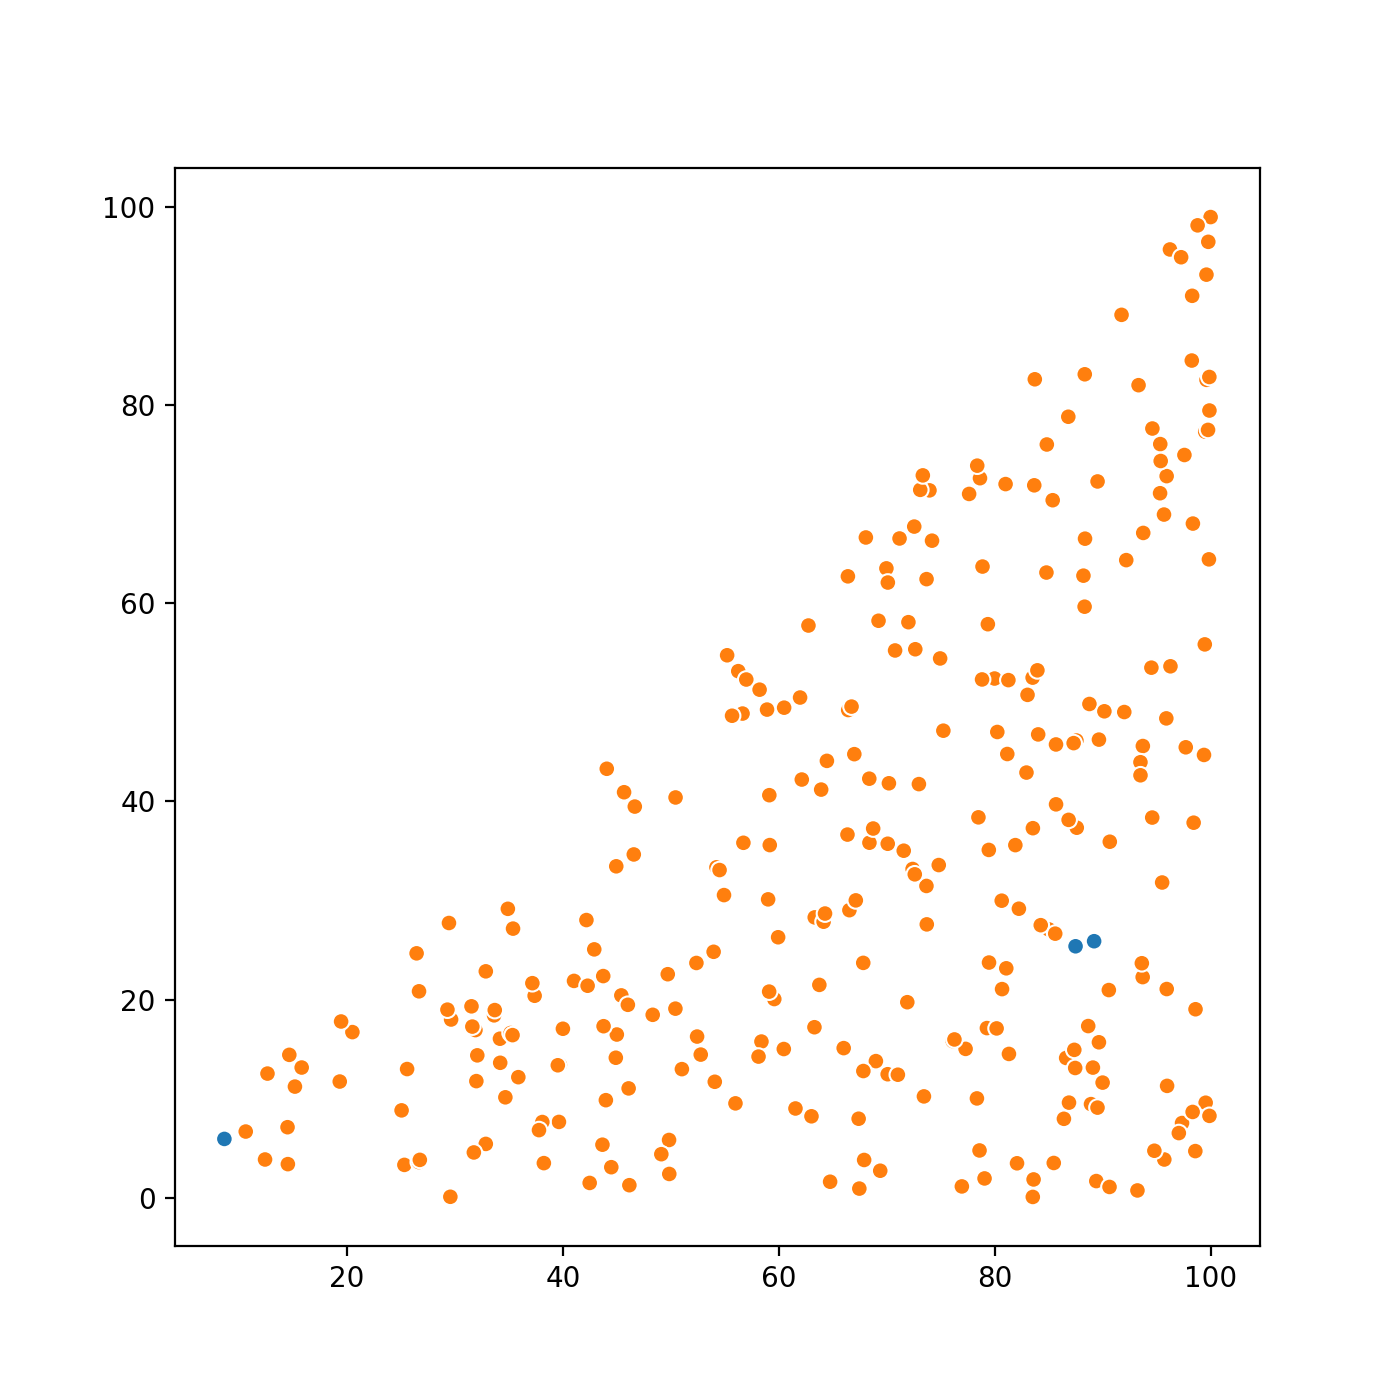

In [434]:
pa2 = post_analysis_multi(points2, res2)
pa2.plot_cloud_point()

<IPython.core.display.Javascript object>


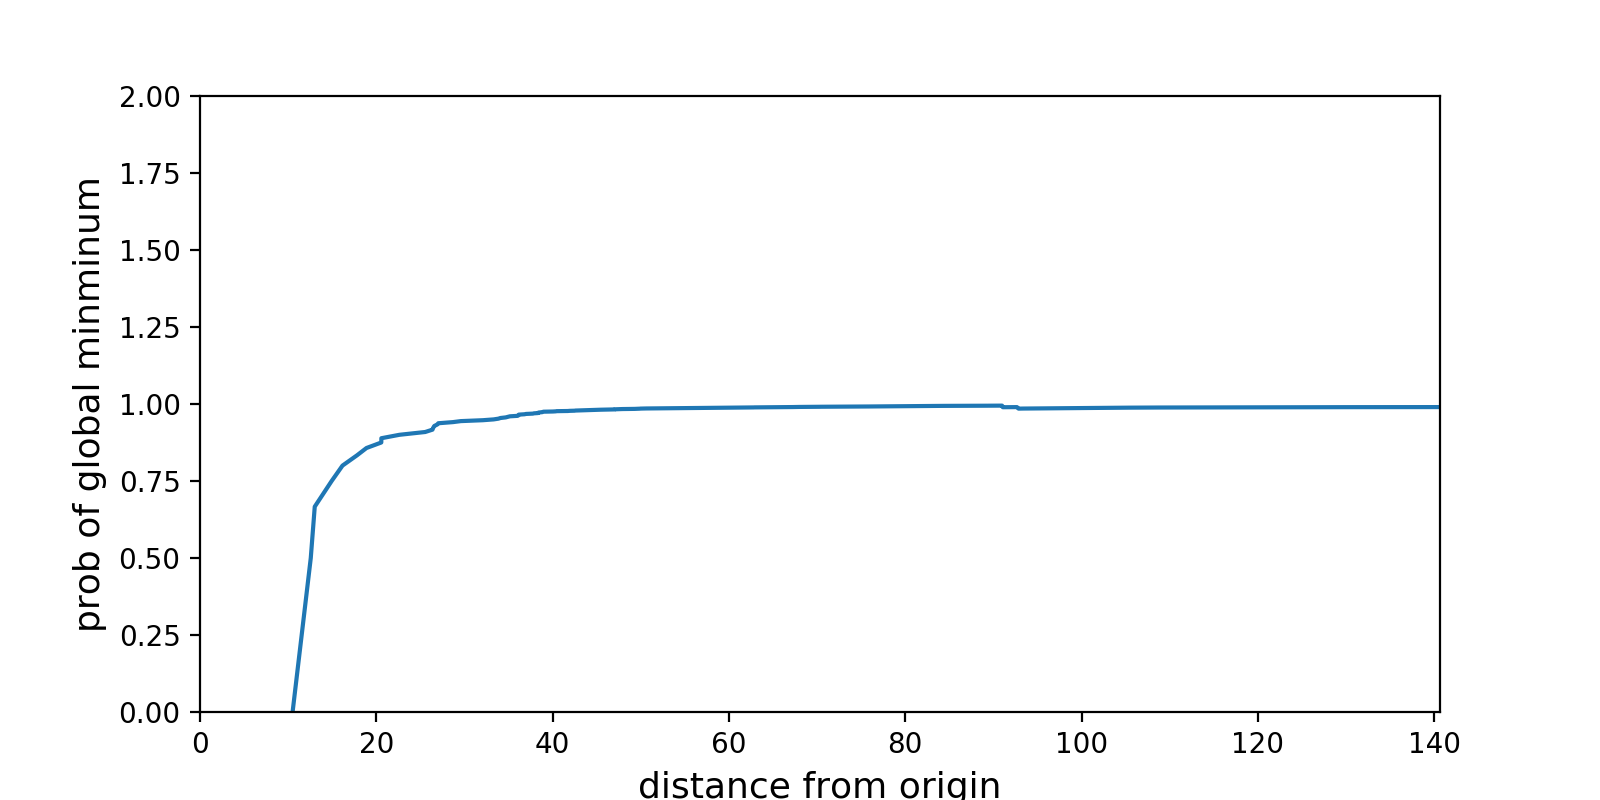

In [437]:
pa2 = post_analysis_multi(points, res)
pa2.plot_prob_vs_radius()

In [436]:
class post_analysis_multi():
    def __init__(self, points, res):
        self.points = points
        self.res = res
        self.num = self.res.shape[0]
    def plot_prob_vs_radius(self, *args):
        def count_global_min(res, points):        
            distance = np.linalg.norm(points, axis=1)
            idx = np.argsort(distance)
            dis_ascending = distance[idx]
            res_ascending = res[idx]
            prob = np.zeros((self.num, ))
            for i in range(self.num):
                prob[i] = np.sum(res_ascending[:i+1] == 1) / (i + 1) 
            return dis_ascending, prob
        argc = len(args)
        assert argc%2 == 0
        pair_cnt = int(argc / 2)
        dis_ascendings = np.zeros((self.num, pair_cnt + 1))
        probs = np.zeros((self.num, pair_cnt + 1))
        dis_ascendings[:,0], probs[:,0] = count_global_min(self.res, self.points)
        for i in range(pair_cnt):
            dis_ascendings[:,i+1], probs[:,i+1] = count_global_min(args[i*2], args[i*2+1])
        fig = plt.figure(figsize=(8,4))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlim(0, np.max(dis_ascendings))
        ax.set_ylim(0, 2)
        ax.set_xlabel('distance from origin', fontsize=13)
        ax.set_ylabel('prob of global minminum', fontsize=13)
        for i in range(pair_cnt+1):
            ax.plot(dis_ascendings[:,i], probs[:,i])
        plt.show()

    def plot_cloud_point(self):
        fig = plt.figure(figsize=(7,7))
        '''
        # one quadrant
        x1 = np.hstack((self.points[:,0], self.points[:,1]))
        y1 = np.hstack((self.points[:,1], self.points[:,0]))
        res1 = np.hstack((self.res, self.res))
        # two qudrant
        x2 = np.hstack((x1, -x1))
        y2 = np.hstack((y1, y1))
        res2 = np.hstack((res1, res1))
        # four qudrant
        x = np.hstack((x2, -x2))
        y = np.hstack((y2, -y2))
        hue = np.hstack((res2, res2))
        '''
        x = self.points[:,0]
        y = self.points[:,1]
        hue = self.res
        p = sns.scatterplot(x=x, y=y, color="r", hue=hue, hue_norm=(0, 1), legend=False)

In [417]:
class single_experiment:
    def set_objective(self, objective_func):
        self.objective_func = objective_func

    def set_optimise(self, optimizer):
        self.optimizer = optimizer

    def do(self):
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
            print("dist_val", np.linalg.norm(optimum - self.objective_func.get_optimum()))
        print(statistics['status'])
        if self.optimizer.record == True:
            return statistics['status']
        else:
            self.analyser = post_analysis(statistics, self.objective_func)

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = default

cma = cma_es()
cma.set_parameters(paras)

# boil down to one expreiment
exp1 = single_experiment()
exp1.set_objective(ak)
exp1.set_optimise(cma)
exp1.do()

In [ ]:
#exp1.analyser.print_mean_variance()

In [ ]:
np.random.seed(34)
# setup objective function
ak = ackley()
# setup adjust function optimizer
line = line_search(alpha=2, beta=0.1)

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = line

cma2 = cma_es()
cma2.set_parameters(paras)

# boil down to one expreiment
exp2 = single_experiment()
exp2.set_objective(ak)
exp2.set_optimise(cma2)
exp2.do()

In [ ]:
exp2.analyser.plot_distance()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
ro = round_off()

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro

cma3 = cma_es()
cma3.set_parameters(paras)

# boil down to one expreiment
exp3 = single_experiment()
exp3.set_objective(ak)
exp3.set_optimise(cma3)
exp3.do()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
l1 = line_search_1step(alpha=1, beta=0.1)

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = l1

cma4 = cma_es()
cma4.set_parameters(paras)

# boil down to one expreiment
exp4 = single_experiment()
exp4.set_objective(ak)
exp4.set_optimise(cma4)
exp4.do()

In [ ]:
exp1.analyser.print_points_before_and_after_adjust()

In [ ]:
exp1.analyser.print_evaluations_per_iteration()

In [ ]:
exp1.analyser.print_mean_variance()

In [ ]:
exp1.analyser.plot_distance()

In [ ]:
ana = post_analysis(statistics, ak)

In [ ]:
ana.plot_distance()

In [ ]:
ana.animate_moving_cluster()

In [ ]:
ana.animate_scatterplot_distance()

In [ ]:
ana.plot_moving_cluster()

In [ ]:
    def generate_point_cloud(self, sigma, alpha, beta, adjust, points):
        self.num = points.shape[0]
        self.res = np.zeros((self.num, ))
        self.points = points

        for i in range(self.num):
            val, arg, stats = cma_es_general(self.points[i].reshape(2,1), sigma, alpha, beta, adjust, 1e-3, self.func, self.dfunc, self.optimal, self.optimum)
            if(stats['status'] == 'd'):
                self.res[i] = 1
            elif(stats['status'] == 'l'):
                self.res[i] = 0.5
            else:
                self.res[i] = 0

